## Table of Contents:
1. [Libraries](#Libraries)
2. [Load data](#Load-data)
3. [Configuration](#Configuration)
4. [Utils](#Utils)
5. [Data Pre-processing](#Data-Pre-processing)
6. [Contrastive loss](#Contrastive-loss)
7. [Models](#Models)
8. [Helper functions](#Helper-functions)
9. [Train](#Train)
10. [Inference](#Inference)

In [1]:
!nvidia-smi

Thu Feb  2 14:05:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Libraries

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import math
import time
import random
from typing import Tuple
from collections import OrderedDict

from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

In [4]:
# load the dataset
training_dir = "data/train"
testing_dir = "data/test"
training_csv = "data/train_data.csv"
testing_csv = "data/test_data.csv"

In [5]:
train = pd.read_csv(training_csv)
train.columns = ["image1", "image2", "label"]
train["image1_path"] = train["image1"].apply(lambda x: f"{training_dir}/{x}")
train["image2_path"] = train["image2"].apply(lambda x: f"{training_dir}/{x}")
test = pd.read_csv(testing_csv)
test.columns = ["image1", "image2", "label"]
test["image1_path"] = test["image1"].apply(lambda x: f"{testing_dir}/{x}")
test["image2_path"] = test["image2"].apply(lambda x: f"{testing_dir}/{x}")

In [6]:
train

,image1,image2,label,image1_path,image2_path
0,068/09_068.png,068_forg/01_0124068.PNG,1,train/068/09_068.png,train/068_forg/01_0124068.PNG
1,068/09_068.png,068_forg/02_0124068.PNG,1,train/068/09_068.png,train/068_forg/02_0124068.PNG
2,068/09_068.png,068_forg/01_0113068.PNG,1,train/068/09_068.png,train/068_forg/01_0113068.PNG
3,068/09_068.png,068_forg/04_0124068.PNG,1,train/068/09_068.png,train/068_forg/04_0124068.PNG
4,068/09_068.png,068_forg/04_0113068.PNG,1,train/068/09_068.png,train/068_forg/04_0113068.PNG
...,...,...,...,...,...
23200,031/02_031.png,031/03_031.png,0,train/031/02_031.png,train/031/03_031.png
23201,031/02_031.png,031/12_031.png,0,train/031/02_031.png,train/031/12_031.png
23202,031/02_031.png,031/11_031.png,0,train/031/02_031.png,train/031/11_031.png
23203,031/02_031.png,031/06_031.png,0,train/031/02_031.png,train/031/06_031.png


Labels:  
0 = original <br>
1 = forgery

In [7]:
train["label"].value_counts(normalize=True)

0    0.543073
1    0.456927
Name: label, dtype: float64

In [8]:
test["label"].value_counts(normalize=True)

1    0.517661
0    0.482339
Name: label, dtype: float64

In [9]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Configuration

In [10]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=128
    num_workers=8
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=3
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3,
        'steps_per_epoch':7, 
        'epochs':7
    }
    batch_size=32
    lr=1e-3
    weight_decay=1e-3
    canvas_size = (952, 1360)
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=train["label"].shape[0]
    nfolds=5
    trn_folds=[0]
    model_name='convnet'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'tresnet_m'
    train=True
    early_stop=True
    target_col="label"
    projection2d=False
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

## Utils

In [12]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

## Data Pre-processing

In [13]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.
    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------
    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size
    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.
        Parameters
        ----------
        img : np.ndarray
            The image to be processed
        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size
    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images
        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    #plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray')
    plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [14]:
train

,image1,image2,label,image1_path,image2_path
0,068/09_068.png,068_forg/01_0124068.PNG,1,train/068/09_068.png,train/068_forg/01_0124068.PNG
1,068/09_068.png,068_forg/02_0124068.PNG,1,train/068/09_068.png,train/068_forg/02_0124068.PNG
2,068/09_068.png,068_forg/01_0113068.PNG,1,train/068/09_068.png,train/068_forg/01_0113068.PNG
3,068/09_068.png,068_forg/04_0124068.PNG,1,train/068/09_068.png,train/068_forg/04_0124068.PNG
4,068/09_068.png,068_forg/04_0113068.PNG,1,train/068/09_068.png,train/068_forg/04_0113068.PNG
...,...,...,...,...,...
23200,031/02_031.png,031/03_031.png,0,train/031/02_031.png,train/031/03_031.png
23201,031/02_031.png,031/12_031.png,0,train/031/02_031.png,train/031/12_031.png
23202,031/02_031.png,031/11_031.png,0,train/031/02_031.png,train/031/11_031.png
23203,031/02_031.png,031/06_031.png,0,train/031/02_031.png,train/031/06_031.png


In [15]:
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)

observation = train.iloc[10]
img1 = load_signature(observation['image1_path'])
img2 = load_signature(observation['image2_path'])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

In [16]:
img1.shape

(136, 481)

In [17]:
observation

image1                        068/02_068.png
image2               068_forg/01_0113068.PNG
label                                      1
image1_path             train/068/02_068.png
image2_path    train/068_forg/01_0113068.PNG
Name: 10, dtype: object

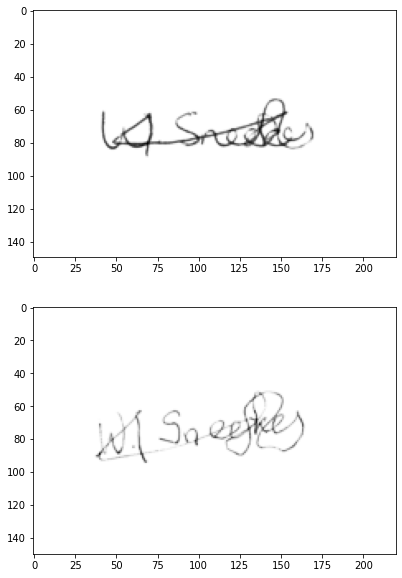

In [18]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

## Dataset

In [19]:
class SignatureDataset(Dataset):
    
    def __init__(self, df, canvas_size, dim=(256, 256)):
        self.df  = df
        self.image1_paths = df["image1_path"].values
        self.image2_paths = df["image2_path"].values
        self.labels = df["label"].values
        self.dim = dim
        self.canvas_size=canvas_size

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        # getting the image path
        image1_path = self.image1_paths[index]
        image2_path = self.image2_paths[index]
        
        img1 = load_signature(image1_path)
        img2 = load_signature(image2_path)
        
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return torch.tensor(img1), torch.tensor(img2), label.float()

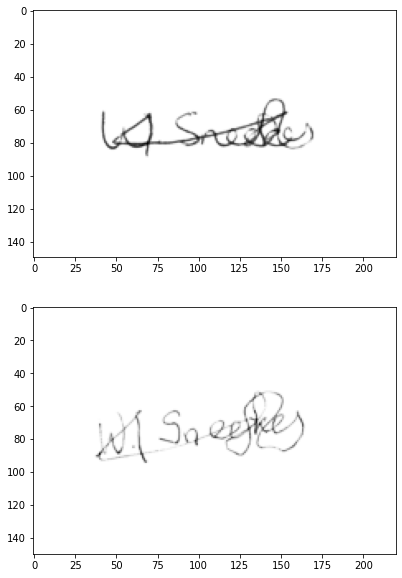

In [20]:
train_dataset = SignatureDataset(train, canvas_size, input_size)
img1, img2, _ = train_dataset[10]

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)

In [21]:
img1.shape

torch.Size([150, 220])

## Contrastive loss

In [22]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(F.normalize(output1), F.normalize(output2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Models

In [23]:
def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.Mish()),
    ]))
    

class SigNet(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super().__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))
    
    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2


class SiameseModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = SigNet()
        
        if CFG.projection2d:
            self.probs = nn.Linear(4, 1)
        else:
            self.probs = nn.Linear(self.model.feature_space_size*2, 1)
        self.projection2d = nn.Linear(self.model.feature_space_size, 2)
    
    def forward_once(self, img):
        x = self.model.forward_once(img)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        # forward pass of input 1
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        embedding1 = self.forward_once(img1)
        # forward pass of input 2
        embedding2 = self.forward_once(img2)
        
        if CFG.projection2d:
            print("Project embeddings into 2d space")
            embedding1 = self.projection2d(embedding1)
            embedding2 = self.projection2d(embedding2)
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output
        else:
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output

## Helper functions

In [24]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterions, optimizer, epoch, scheduler, device):
    
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (img1, img2, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        out1, out2, preds = model(img1, img2)
        loss1 = criterions[0](out1, out2, labels)
        loss2 = criterions[1](preds.squeeze(1), labels)
        loss = (loss1 + loss2) / 2
            
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print(f'Epoch: [{epoch}][{step}/{len(train_loader)}] ', end='')
            print(f'Elapsed: {timeSince(start, float(step+1)/len(train_loader))} ', end='')
            print(f'Loss: {losses.val:.4f}({losses.avg:.4f}) ', end='')
            print(f'Grad: {grad_norm:.4f} ', end='')
            if scheduler:
                print(f'LR: {scheduler.get_last_lr()[0]:.6f}  ')
            else:
                print(f'LR: {CFG.lr}')
            
    return losses.avg

## Train

In [25]:
# ====================================================
# loader
# ====================================================
seed_torch(seed=CFG.seed)


train_dataset = SignatureDataset(train, CFG.canvas_size, dim=(256, 256))

train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
   
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
    return scheduler

# ====================================================
# model & optimizer
# ====================================================
model = SiameseModel()
model.to(device)
    

optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
try:
    scheduler = get_scheduler(optimizer)
except:
    print('Learning scheduler is not used')

# ====================================================
# loop
# ====================================================
contrastive = ContrastiveLoss() # Contrastive loss
binary_cross = nn.BCEWithLogitsLoss() # Binary cross entropy
best_score = 0.
best_loss = np.inf
    
for epoch in range(CFG.epochs):
        
    start_time = time.time()
        
    # train
    avg_loss = train_fn(train, train_loader, model, [contrastive, binary_cross], optimizer, epoch, scheduler, device)

        
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, OneCycleLR):
        scheduler.step()


    elapsed = time.time() - start_time

    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')           
            
    if avg_loss < best_loss:
        best_loss = avg_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict()}, 
                        OUTPUT_DIR+f'{CFG.model_name}_best_loss.pt')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0][0/725] Elapsed: 0m 55s (remain 670m 1s) Loss: 0.5839(0.5839) Grad: 9.4818 LR: 0.001000  
Epoch: [0][100/725] Elapsed: 5m 42s (remain 35m 16s) Loss: 0.2836(0.4125) Grad: 1.5360 LR: 0.001000  
Epoch: [0][200/725] Elapsed: 10m 37s (remain 27m 41s) Loss: 0.1767(0.3226) Grad: 0.9851 LR: 0.001000  
Epoch: [0][300/725] Elapsed: 15m 10s (remain 21m 22s) Loss: 0.1207(0.2595) Grad: 1.0325 LR: 0.001000  
Epoch: [0][400/725] Elapsed: 19m 57s (remain 16m 7s) Loss: 0.1062(0.2241) Grad: 1.5427 LR: 0.001000  
Epoch: [0][500/725] Elapsed: 24m 51s (remain 11m 6s) Loss: 0.0698(0.2009) Grad: 0.6647 LR: 0.001000  
Epoch: [0][600/725] Elapsed: 29m 35s (remain 6m 6s) Loss: 0.1177(0.1796) Grad: 1.5813 LR: 0.001000  
Epoch: [0][700/725] Elapsed: 34m 25s (remain 1m 10s) Loss: 0.1938(0.1663) Grad: 1.8369 LR: 0.001000  


Epoch 1 - avg_train_loss: 0.1640  time: 2113s
INFO:__main__:Epoch 1 - avg_train_loss: 0.1640  time: 2113s
Epoch 1 - Save Best Loss: 0.1640 Model
INFO:__main__:Epoch 1 - Save Best Loss: 0.1640 Model


Epoch: [0][724/725] Elapsed: 35m 12s (remain 0m 0s) Loss: 0.1035(0.1640) Grad: 1.2902 LR: 0.001000  
Epoch: [1][0/725] Elapsed: 0m 25s (remain 303m 54s) Loss: 0.1984(0.1984) Grad: 2.0850 LR: 0.000855  
Epoch: [1][100/725] Elapsed: 5m 0s (remain 30m 57s) Loss: 0.0390(0.0762) Grad: 0.3394 LR: 0.000855  
Epoch: [1][200/725] Elapsed: 9m 55s (remain 25m 52s) Loss: 0.0380(0.0725) Grad: 0.4134 LR: 0.000855  
Epoch: [1][300/725] Elapsed: 14m 36s (remain 20m 34s) Loss: 0.0610(0.0759) Grad: 0.6748 LR: 0.000855  
Epoch: [1][400/725] Elapsed: 19m 31s (remain 15m 46s) Loss: 0.0284(0.0675) Grad: 0.3183 LR: 0.000855  
Epoch: [1][500/725] Elapsed: 24m 8s (remain 10m 47s) Loss: 0.0326(0.0666) Grad: 0.3830 LR: 0.000855  
Epoch: [1][600/725] Elapsed: 28m 59s (remain 5m 58s) Loss: 0.0663(0.0635) Grad: 0.7563 LR: 0.000855  
Epoch: [1][700/725] Elapsed: 33m 39s (remain 1m 9s) Loss: 0.0554(0.0596) Grad: 1.4187 LR: 0.000855  
Epoch: [1][724/725] Elapsed: 34m 32s (remain 0m 0s) Loss: 0.0355(0.0590) Grad: 0.999

Epoch 2 - avg_train_loss: 0.0590  time: 2073s
INFO:__main__:Epoch 2 - avg_train_loss: 0.0590  time: 2073s
Epoch 2 - Save Best Loss: 0.0590 Model
INFO:__main__:Epoch 2 - Save Best Loss: 0.0590 Model


Epoch: [2][0/725] Elapsed: 0m 22s (remain 269m 16s) Loss: 0.0458(0.0458) Grad: 0.8698 LR: 0.000505  
Epoch: [2][100/725] Elapsed: 4m 58s (remain 30m 42s) Loss: 0.0184(0.0472) Grad: 0.3025 LR: 0.000505  
Epoch: [2][200/725] Elapsed: 9m 54s (remain 25m 49s) Loss: 0.0259(0.0372) Grad: 0.4236 LR: 0.000505  
Epoch: [2][300/725] Elapsed: 14m 27s (remain 20m 22s) Loss: 0.0265(0.0323) Grad: 0.2717 LR: 0.000505  
Epoch: [2][400/725] Elapsed: 19m 21s (remain 15m 38s) Loss: 0.0148(0.0306) Grad: 0.3627 LR: 0.000505  
Epoch: [2][500/725] Elapsed: 23m 56s (remain 10m 42s) Loss: 0.0237(0.0291) Grad: 0.3541 LR: 0.000505  
Epoch: [2][600/725] Elapsed: 28m 49s (remain 5m 56s) Loss: 0.0569(0.0280) Grad: 1.4898 LR: 0.000505  
Epoch: [2][700/725] Elapsed: 33m 22s (remain 1m 8s) Loss: 0.0306(0.0289) Grad: 0.4491 LR: 0.000505  
Epoch: [2][724/725] Elapsed: 34m 20s (remain 0m 0s) Loss: 0.0208(0.0288) Grad: 0.4281 LR: 0.000505  


Epoch 3 - avg_train_loss: 0.0288  time: 2060s
INFO:__main__:Epoch 3 - avg_train_loss: 0.0288  time: 2060s
Epoch 3 - Save Best Loss: 0.0288 Model
INFO:__main__:Epoch 3 - Save Best Loss: 0.0288 Model


## Inference

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


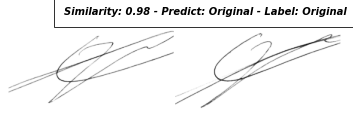

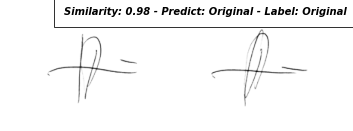

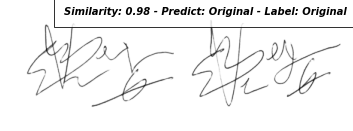

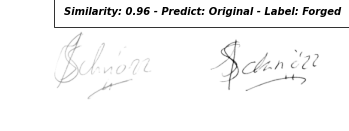

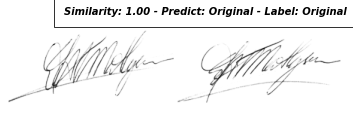

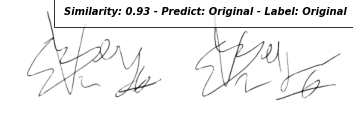

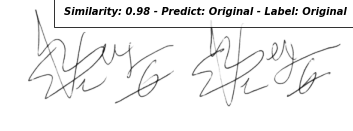

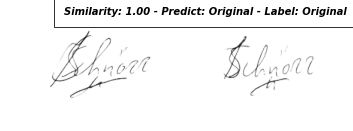

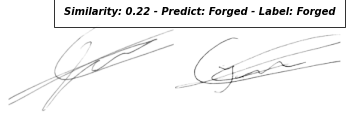

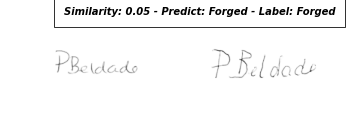

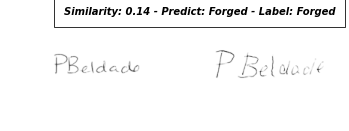

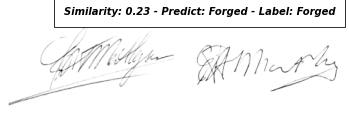

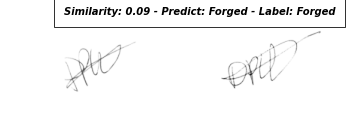

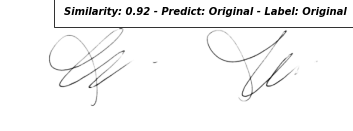

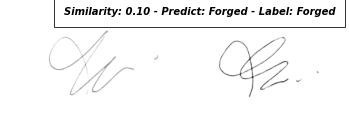

In [31]:
seed_torch(seed=CFG.seed)
model = SiameseModel()
model.load_state_dict(torch.load('./convnet_best_loss.pt')['model'])


test_dataset = SignatureDataset(test, CFG.canvas_size, dim=(256, 256))

test_loader = DataLoader(test_dataset,
                              batch_size=1, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

counter = 0 
num_true_predict = 0
num_false_predict = 0
label_dict = {1.0:'Forged', 0.0:'Original'}
CFG.projection2d=False
model.eval()
for i, data in enumerate(test_loader, 0):
    counter+=1
    img1, img2, label = data
    concatenated = torch.cat((img1, img2),0)
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    # confidence = confidence.sigmoid().detach().to('cpu')
    # if label == 0.0:
    #     confidence = 1 - confidence
    cos_sim = F.cosine_similarity(op1, op2)
    similarity_score = abs(cos_sim.item())
    predict = 0.0 if similarity_score > 0.5 else 1.0
    if predict == label:
        num_true_predict += 1
    else:
        num_false_predict += 1
    
    if counter<=15:
        imshow(torchvision.utils.make_grid(concatenated.unsqueeze(1)), f'Similarity: {similarity_score:.2f} - Predict: {label_dict[predict]} - Label: {label_dict[label.item()]}')


In [33]:
accuracy = num_true_predict/(num_true_predict+num_false_predict)
print(accuracy)

0.9411867061075344
